In [1]:
import time

import jax
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.lines import Line2D
from matplotlib.container import ErrorbarContainer
import numpy as np
from tqdm.notebook import tqdm, trange
from tueplots import bundles

from glob import glob
import pandas as pd

from laurel import mdp, control
from oetils.plotting import init_plotting

In [2]:
# plt.rcParams.update(bundles.neurips2023())
# W = init_plotting(publish=True, W=plt.rcParams['figure.figsize'][0])

init_plotting(publish=True)
latex = plt.rcParams['text.latex.preamble']
plt.rcParams.update(bundles.neurips2023())
plt.rcParams['text.latex.preamble'] = latex + plt.rcParams['text.latex.preamble']
W, _ = plt.rcParams['figure.figsize']

plt.rcParams.update({
    'grid.linestyle': ':',
    'legend.fancybox': False,
    'patch.linewidth': 0.5,
    'legend.edgecolor': 'inherit',
    'legend.framealpha': 0.8,
    'lines.linewidth': 1,
    'font.family': 'latin'
})

cycle = plt.rcParams['axes.prop_cycle']

In [3]:
nums_parcels = [10, 20, 50, 100, 200, 500, 1000]
num_trials = 5

rng = np.random.default_rng(42)
key = jax.random.PRNGKey(42)

I0000 00:00:1699815969.151498       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [4]:
# Initialize training MDP.
env = mdp.MiddleMileMDP(
    num_hubs=10,
    timesteps=50,
    num_trucks_per_step=10,
    max_truck_duration=5,
    num_parcels=nums_parcels,
    mean_route_length=10,
    unit_weights=True,
    unit_capacities=True,
)

In [5]:
nums_hubs = [5, 10, 20, 50]
random_perf = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))
greedy_perf = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))
times = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))
iterations = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))

for i, num_hubs in enumerate(tqdm(nums_hubs)):
  for j, num_parcels in enumerate(tqdm(nums_parcels, leave=False)):
    for k in range(num_trials):
      timesteps = 50
      num_trucks_per_step = num_hubs

      # Create middle-mile environment and initialize state.
      env = mdp.MiddleMileMDP(
          num_hubs=num_hubs,
          timesteps=timesteps,
          num_trucks_per_step=num_trucks_per_step,
          max_truck_duration=5,
          num_parcels=num_parcels,
          mean_route_length=10,
          unit_weights=True,
          unit_capacities=True,
      )
      init_state, _ = env.reset(rng)

      # Random
      start = time.time()
      state = init_state
      steps = 0
      deliveries = 0
      while True:
        steps += 1
        # Get next parcel and available trucks.
        state, parcel, trucks = env.get_actions(state, prune_parcel=False)
        if parcel is None:
          break

        # Put parcel onto random truck, get next state.
        truck = rng.choice(trucks)
        state, delivery, _ = env.step(parcel, truck, state, prune=False)
        deliveries += delivery

      times[i, j, k] = time.time() - start
      iterations[i, j, k] = steps
      random_perf[i, j, k] = deliveries / num_parcels

      # Greedy
      state = init_state
      deliveries = 0
      while True:
        # Get next parcel and available trucks.
        state, feature_graph, parcel, trucks = env.get_feature_graph(
          1, state, min_phantom_weight=None, prune_parcel=False
        )
        if parcel is None:
          break
        parcel = parcel[0]

        # Put parcel truck, get next state.
        truck_ids = list(trucks.keys())
        truck = trucks[truck_ids[np.argmin(
          feature_graph.nodes[feature_graph.receivers[truck_ids]][:, 2]
        )]]
        state, delivery, _ = env.step(parcel, truck, state, prune=False)
        deliveries += delivery

      greedy_perf[i, j, k] = deliveries / num_parcels

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
# Load supervised learning results.
gnn_perf = np.load('../out/sl_gnn_perf.npy')
linear_perf = np.load('../out/sl_linear_perf.npy')

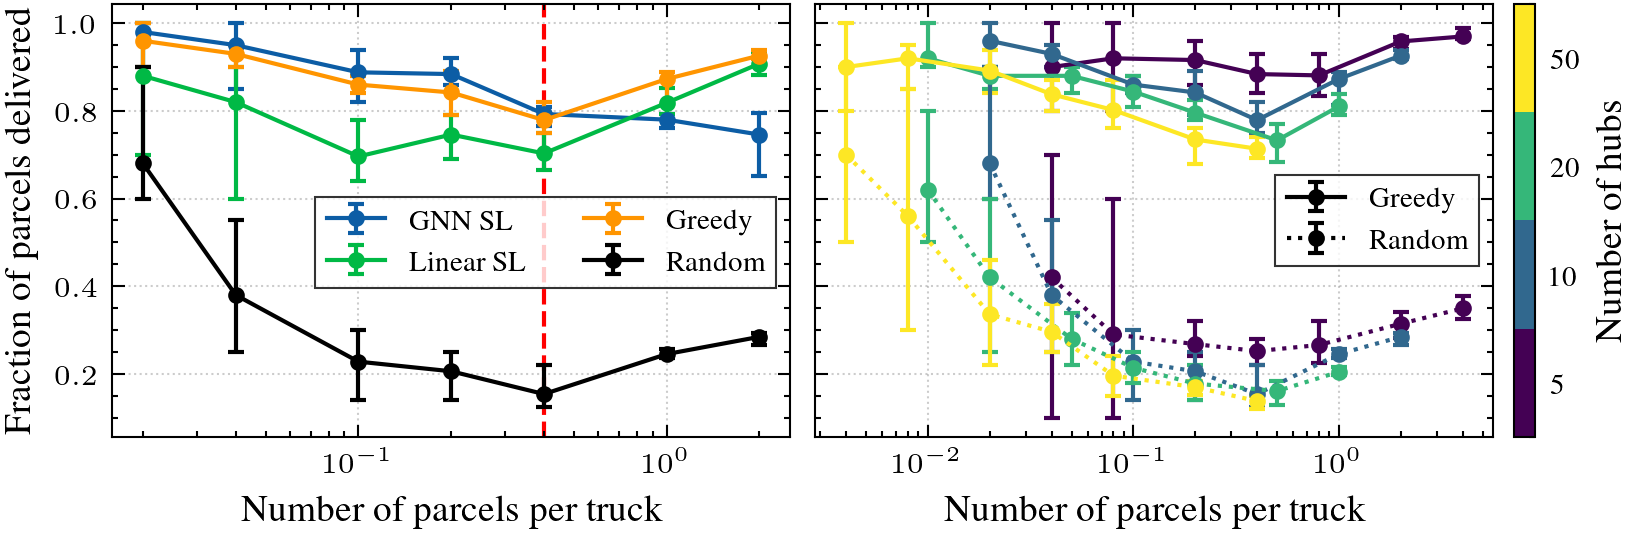

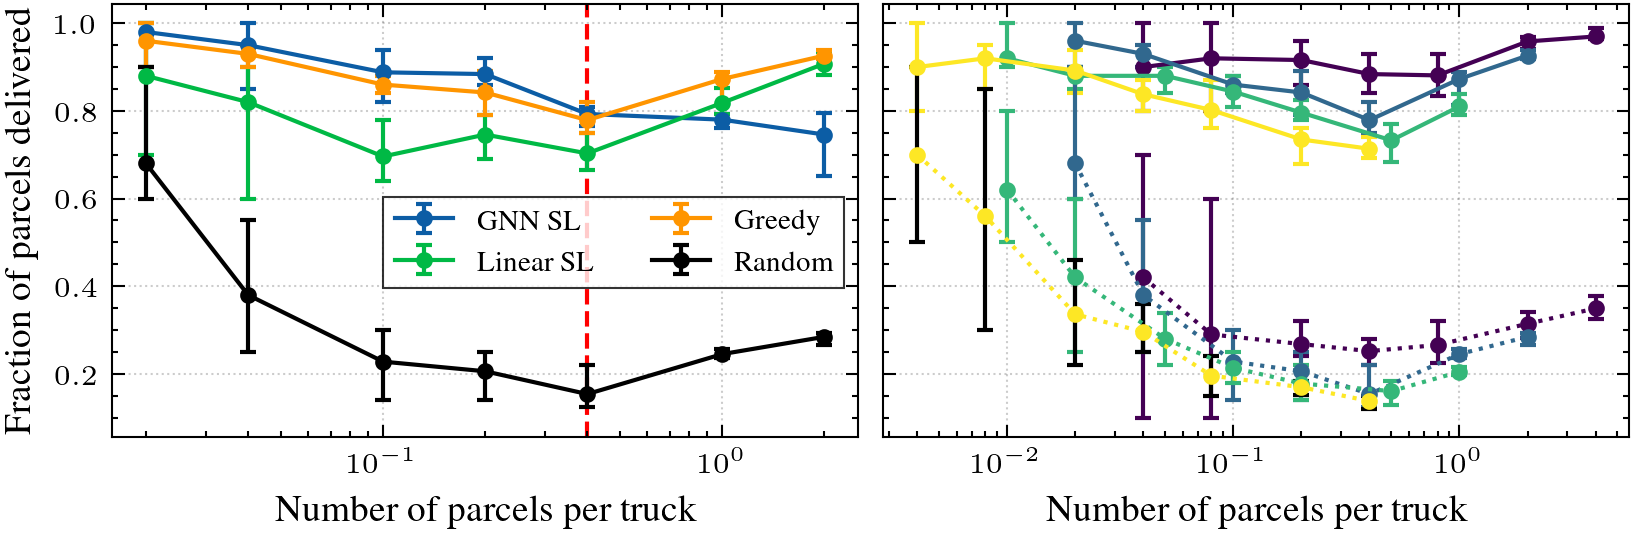

In [7]:
cmap = cm.viridis
norm = BoundaryNorm(range(len(nums_hubs) + 1), cmap.N)
plt.rcParams['axes.prop_cycle'] = cycle

# Plot performances.
fig, ax = plt.subplots(1, 2, figsize=(W, W/3), sharey=True)
ax[0].set_xlabel("Number of parcels per truck")
ax[0].set_ylabel("Fraction of parcels delivered")
ax[0].set_xscale('log')
ax[1].set_xlabel("Number of parcels per truck")
ax[1].set_xscale('log')

nums_hubs = [5, 10, 20, 50]
num_hubs = 10
timesteps = 50
parcel_per_truck = np.array(nums_parcels) / (num_hubs * timesteps)
ax[0].errorbar(
    parcel_per_truck,
    np.nanmean(gnn_perf, 1),
    np.stack([
        np.nanmean(gnn_perf, 1) - np.nanmin(gnn_perf, 1),
        np.nanmax(gnn_perf, 1) - np.nanmean(gnn_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'GNN SL'
)
ax[0].errorbar(
    parcel_per_truck,
    np.nanmean(linear_perf, 1),
    np.stack([
        np.nanmean(linear_perf, 1) - np.nanmin(linear_perf, 1),
        np.nanmax(linear_perf, 1) - np.nanmean(linear_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'Linear SL'
)
ax[0].errorbar(
    parcel_per_truck,
    np.nanmean(greedy_perf[1], 1),
    np.stack([
        np.nanmean(greedy_perf[1], 1) - np.nanmin(greedy_perf[1], 1),
        np.nanmax(greedy_perf[1], 1) - np.nanmean(greedy_perf[1], 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'Greedy'
)
ax[0].errorbar(
    parcel_per_truck,
    np.nanmean(random_perf[1], 1),
    np.stack([
        np.nanmean(random_perf[1], 1) - np.nanmin(random_perf[1], 1),
        np.nanmax(random_perf[1], 1) - np.nanmean(random_perf[1], 1)
    ]),
    fmt='k.-',
    capsize=2,
    label=f'Random'
)
ax[0].axvline(parcel_per_truck[-3], c='r', zorder=0, ls='--')
ax[0].legend(ncol=2, loc='center right', bbox_to_anchor=(1, 0.45))

for i, num_hubs in enumerate(nums_hubs):
    timesteps = 50
    parcel_per_truck = np.array(nums_parcels) / (num_hubs * timesteps)
    ax[1].errorbar(
        parcel_per_truck,
        np.nanmean(greedy_perf[i], 1),
        np.stack([
            np.nanmean(greedy_perf[i], 1) - np.nanmin(greedy_perf[i], 1), 
            np.nanmax(greedy_perf[i], 1) - np.nanmean(greedy_perf[i], 1)
        ]),
        fmt='.-',
        color=cmap(norm(i)),
        capsize=2,
    )
for i, num_hubs in enumerate(nums_hubs):
    timesteps = 50
    parcel_per_truck = np.array(nums_parcels) / (num_hubs * timesteps)
    ebc = ax[1].errorbar(
        parcel_per_truck,
        np.nanmean(random_perf[i], 1),
        np.stack([
            np.nanmean(random_perf[i], 1) - np.nanmin(random_perf[i], 1), 
            np.nanmax(random_perf[i], 1) - np.nanmean(random_perf[i], 1)
        ]),
        fmt=f'.:',
        color=cmap(norm(i)),
        capsize=2,
    )

# The copying will output multiple plots, but savefig only saves one plot.
from copy import deepcopy
_, caps, errs = deepcopy(ebc)
for cap in caps:
    cap.set_color('k')
for err in errs:
    err.set_color('k')
ebc1 = ErrorbarContainer((Line2D([],[], color='k', marker='.'), caps, errs), has_yerr=True, label='Greedy')
ebc2 = ErrorbarContainer((Line2D([],[], ls=':', color='k', marker='.'), caps, errs), has_yerr=True, label='Random')
ax[1].legend(handles=[ebc1, ebc2])

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1], pad=0.03)
cbar.set_ticks(np.arange(len(nums_hubs)) + 0.5)
cbar.set_ticklabels(nums_hubs)
# cbar.ax.tick_params(length=2, width=0.5, direction='out')
cbar.set_label(r'Number of hubs')

fig.savefig('../out/hubs-supervised.pdf')

In [5]:
function_types = []
actor_lrs = []
critic_lrs = []
num_updates = []
num_rollouts = []
performances = []
explorations = []
paths = []
for suffix in ['', '-fix', '-fix2']:
    for path_perf, path_exp, path_params in zip(
            glob(f'../dat/runs/ppo{suffix}/working_directories/*/performance.npy'),
            glob(f'../dat/runs/ppo{suffix}/working_directories/*/exploration.npy'),
            glob(f'../dat/runs/ppo{suffix}/working_directories/*/param_choice.csv')
        ):
        params = pd.read_csv(path_params)
        if 'num_updates' not in params.keys():
            continue
        paths.append(path_params)
        performances.append(np.load(path_perf))
        explorations.append(np.load(path_exp))
        function_types.append(params['function_type'].values[0])
        actor_lrs.append(params['actor_lr'].values[0])
        critic_lrs.append(params['critic_lr'].values[0])
        num_updates.append(params['num_updates'].values[0])
        num_rollouts.append(params['num_rollouts'].values[0])

paths = np.array(paths)
performances = np.array([p.mean(-1).reshape(100, -1).mean(-1) for p in performances])
explorations = np.array([e.mean(-1).reshape(100, -1).mean(-1) for e in explorations])
function_types = np.array(function_types)
explorations[function_types == 'linear'] = 1 - explorations[function_types == 'linear']
actor_lrs = np.array(actor_lrs)
critic_lrs = np.array(critic_lrs)
num_updates = np.array(num_updates)
num_rollouts = np.array(num_rollouts)
fts = np.unique(function_types)
alrs = np.unique(actor_lrs)
clrs = np.unique(critic_lrs)
nus = np.unique(num_updates)
nrs = np.unique(num_rollouts)

final_perfs = np.array([[[[[
    np.median(performances[
        (function_types == ft) & (actor_lrs == alr) & (critic_lrs == clr) 
        & (num_updates == nu) & (num_rollouts == nr), -10:
    ])
    for nr in nrs]
    for nu in nus]
    for clr in clrs]
    for alr in alrs]
    for ft in fts]
)

from functools import reduce
parameters = [actor_lrs, critic_lrs, num_updates, num_rollouts]
param_vals = [alrs, clrs, nus, nrs]
idx_gnn = np.unravel_index(np.nanargmax(final_perfs[fts == 'gnn']), final_perfs[0].shape)
best_gnn = performances[(function_types == 'gnn') & reduce(np.logical_and, [p == v[i] for p, v, i in zip(parameters, param_vals, idx_gnn)])]
idx_linear = np.unravel_index(np.nanargmax(final_perfs[fts == 'linear']), final_perfs[0].shape)
best_linear = performances[(function_types == 'linear') & reduce(np.logical_and, [p == v[i] for p, v, i in zip(parameters, param_vals, idx_linear)])]

/Users/onno/projects/laurel/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/onno/projects/laurel/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


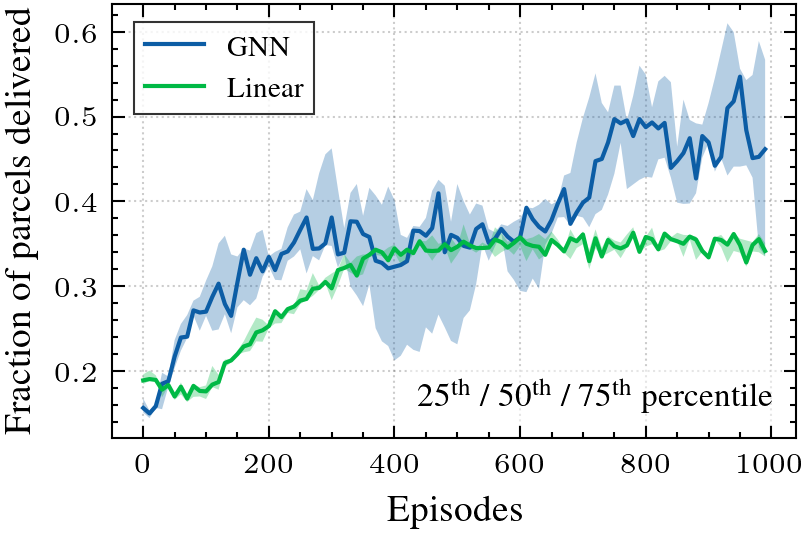

In [7]:
plt.rcParams['axes.prop_cycle'] = cycle

fig, ax = plt.subplots(figsize=(W/2, W/3))
ax.set_ylabel('Fraction of parcels delivered')
ax.set_xlabel('Episodes')
ax.plot(np.arange(0, 1000, 10), np.median(best_gnn, 0), label='GNN')
ax.fill_between(np.arange(0, 1000, 10), np.quantile(best_gnn, 0.25, 0), np.quantile(best_gnn, 0.75, 0), alpha=0.3)

ax.plot(np.arange(0, 1000, 10), np.median(best_linear, 0), label='Linear')
ax.fill_between(np.arange(0, 1000, 10), np.quantile(best_linear, 0.25, 0), np.quantile(best_linear, 0.75, 0), alpha=0.3)

# ax.plot(np.mean(best_gnn, 0), label='GNN')
# ax.fill_between(np.arange(100), best_gnn.min(0), best_gnn.max(0), alpha=0.3)

# ax.plot(np.mean(best_linear, 0), label='Linear')
# ax.fill_between(np.arange(100), best_linear.min(0), best_linear.max(0), alpha=0.3)
# ax.fill_between(np.arange(100), np.quantile(best_linear, 0.25, 0), np.quantile(best_linear, 0.75, 0), alpha=0.3)

ax.text(1000, 0.16, r'25\textsuperscript{th} / 50\textsuperscript{th} / 75\textsuperscript{th} percentile', ha='right', va='baseline', fontsize=8, bbox=dict(facecolor='white', alpha=0.5, ec='none', boxstyle='square'))
# ax.text(100, 0.16, r'min / mean / max', ha='right', va='baseline', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))

fig.savefig('../out/rl.pdf')

In [301]:
print(f"Actor lr: {alrs[idx_gnn[0]]}, critic lr: {clrs[idx_gnn[1]]}, num updates: {nus[idx_gnn[2]]}, num rollouts: {nrs[idx_gnn[3]]}")

Actor lr: 0.0001, critic lr: 0.001, num updates: 50, num rollouts: 5


In [302]:
print(f"Actor lr: {alrs[idx_linear[0]]}, critic lr: {clrs[idx_linear[1]]}, num updates: {nus[idx_linear[2]]}, num rollouts: {nrs[idx_linear[3]]}")

Actor lr: 0.01, critic lr: 0.01, num updates: 50, num rollouts: 1


# Appendix

In [114]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint

from laurel import graph_utils

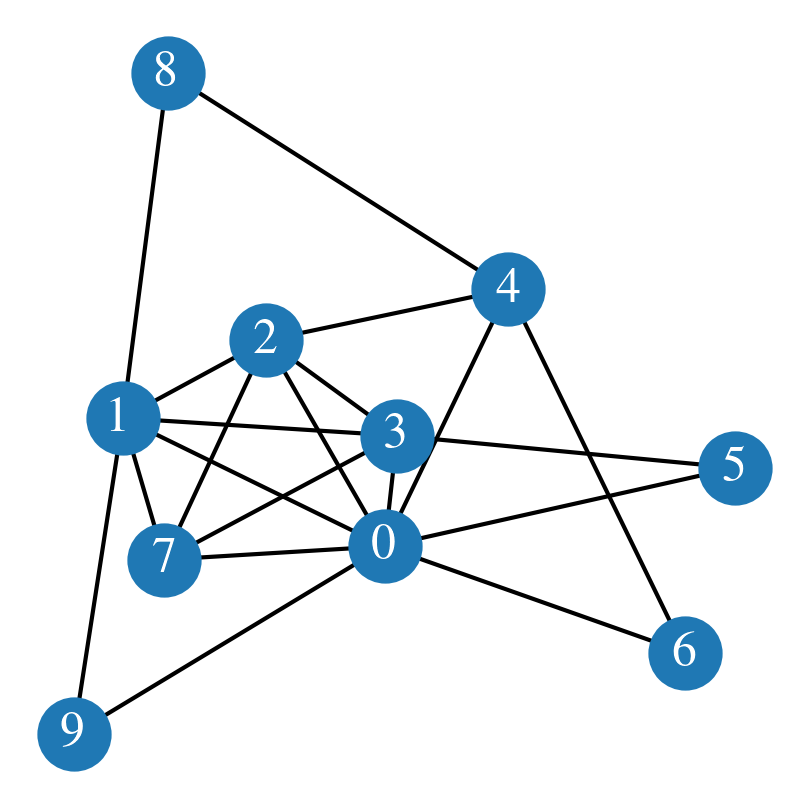

In [115]:
num_hubs = 10  # Number of depots in the network.
timesteps = 20  # Number of time steps.
num_parcels = 100  # Number of parcels in the network.

# Generate and plot random time-expanded transportation network.
rng = np.random.default_rng(seed=42)
state, network, distances = graph_utils.make_random_network(
    rng=rng,
    num_hubs=num_hubs,
    timesteps=timesteps,
    num_trucks_per_step=num_hubs,
    max_truck_duration=timesteps // 2,
)
unpruned_state = state
fig, ax = plt.subplots(figsize=(W/2, W/2))
# graph_utils.draw_network(state, ax=ax[0])
nx.draw(network.to_undirected(), ax=ax, with_labels=True, font_color='w')
# fig.savefig('../out/static-net.pdf')

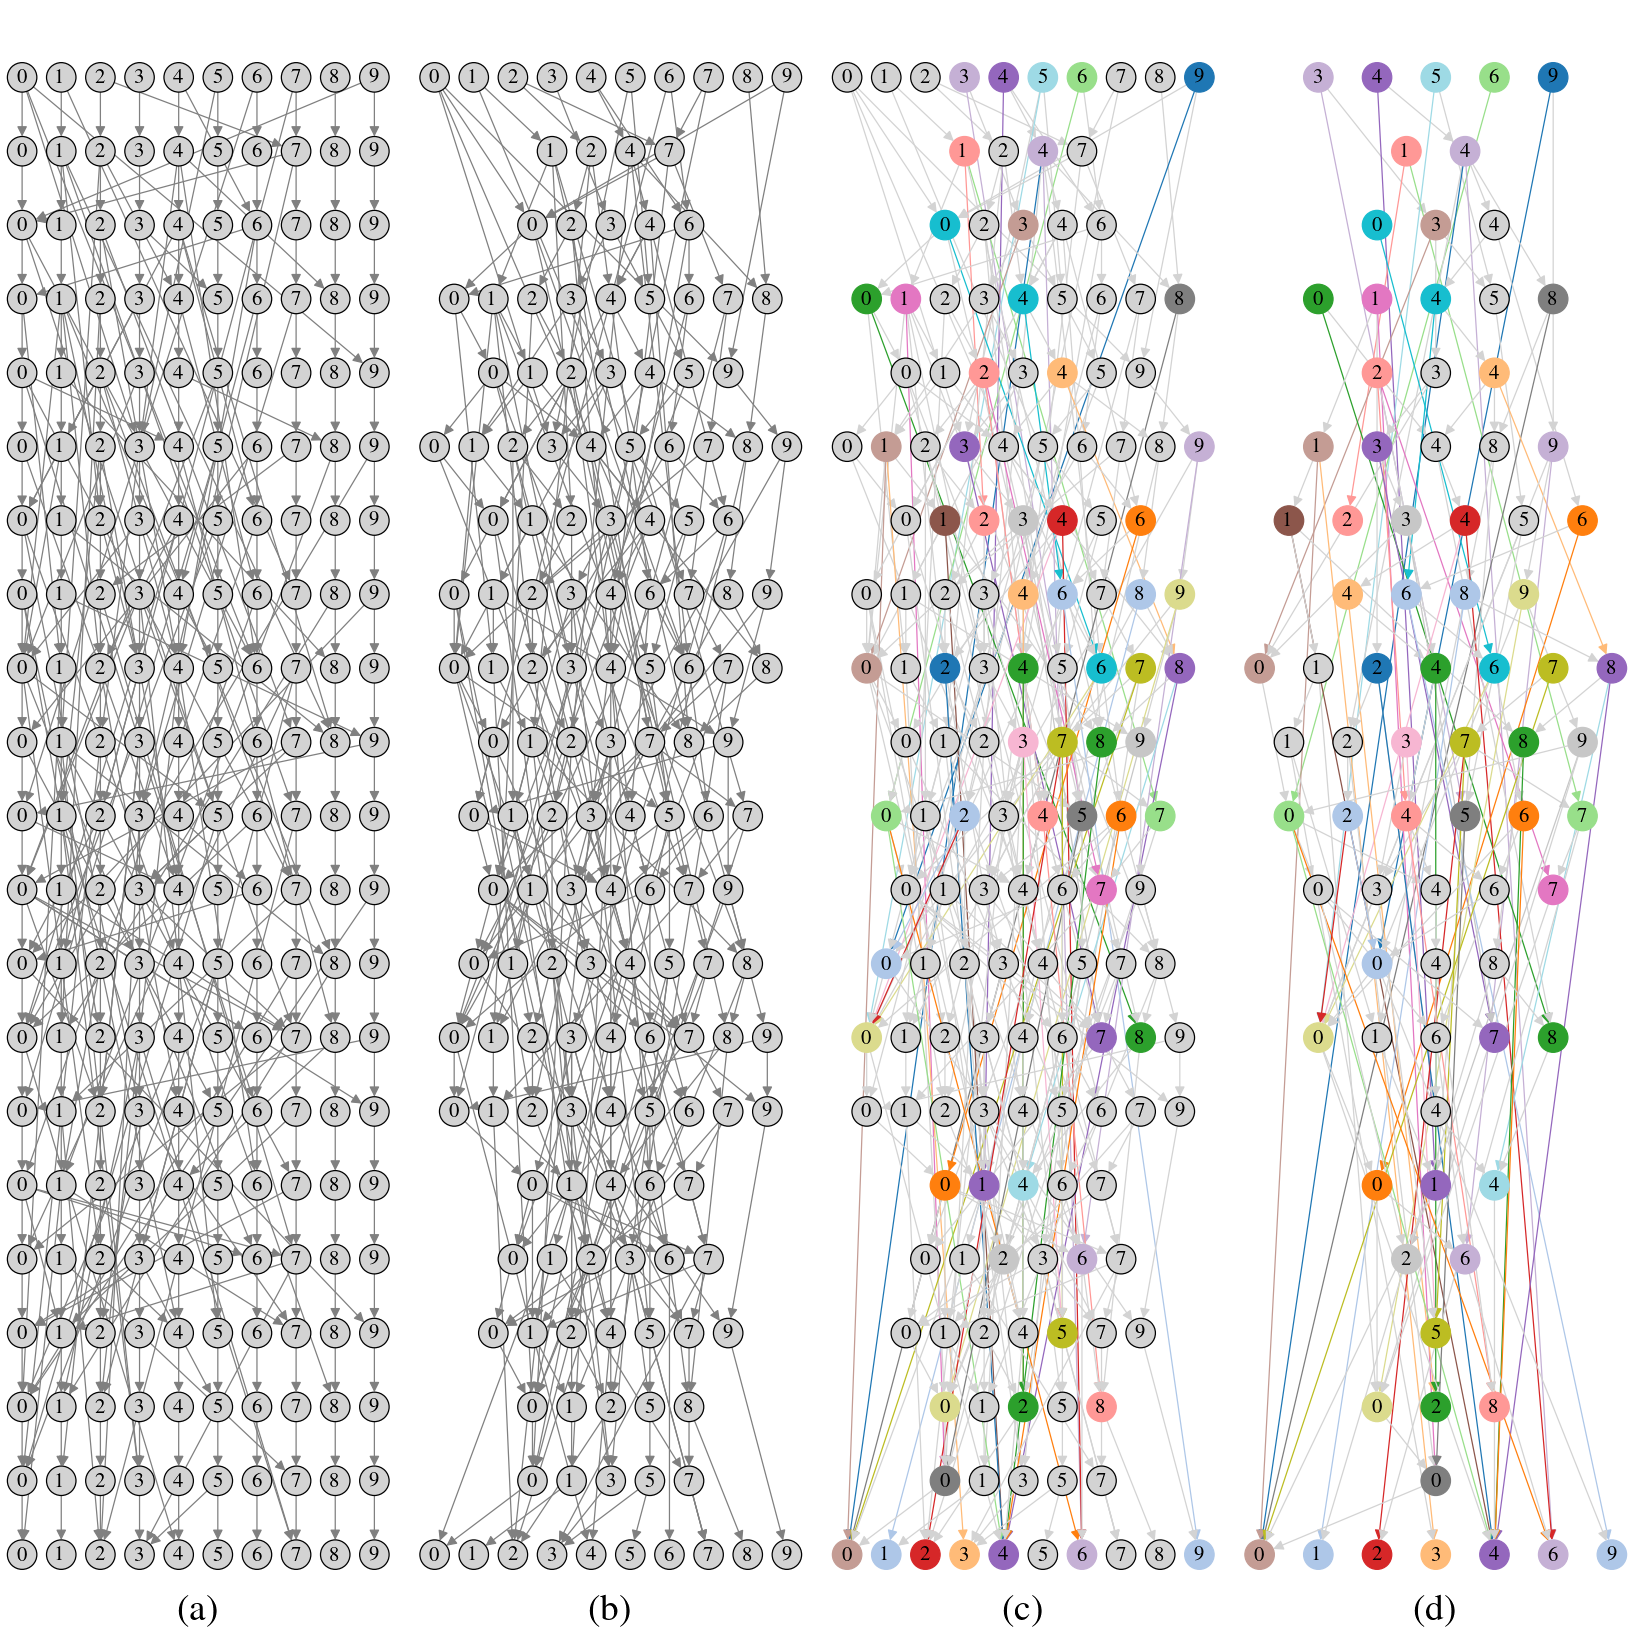

In [116]:
num_hubs = 10  # Number of depots in the network.
timesteps = 20  # Number of time steps.
num_parcels = 50  # Number of parcels in the network.

# Generate and plot random time-expanded transportation network.
rng = np.random.default_rng(seed=42)
state1, network, distances = graph_utils.make_random_network(
    rng=rng,
    num_hubs=num_hubs,
    timesteps=timesteps,
    num_trucks_per_step=num_hubs,
    max_truck_duration=timesteps // 2,
)
# Prune.
state2, new_connections, *_ = graph_utils.prune_network(state1, prune_parcels=False)

# Add parcels to the network and plot solutions.
state3, solution = graph_utils.make_random_parcels(
    rng=rng,
    state=state2,
    network=network,
    distances=distances,
    num_parcels=num_parcels,
    mean_route_length=timesteps // 2,
    cut_capacities=1
)

# Prune network.
state4, new_connections, edge_parcels, solution = graph_utils.prune_network(state3, solution=solution)


# from cycler import cycler
#  = cycler(color='bgrcmyk')
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.get_cmap('tab20').colors)


fig, ax = plt.subplots(1, 4, figsize=(W, W))
graph_utils.draw_network(state1, ax=ax[0], draw_kwargs={'node_size': 50, 'font_size': 5, 'width': 0.3, 'arrowsize': 5, 'linewidths': 0.3})
graph_utils.draw_network(state2, ax=ax[1], draw_kwargs={'node_size': 50, 'font_size': 5, 'width': 0.3, 'arrowsize': 5, 'linewidths': 0.3})
graph_utils.draw_network(state3, ax=ax[2], draw_kwargs={'node_size': 50, 'font_size': 5, 'width': 0.3, 'arrowsize': 5, 'linewidths': 0.3})
graph_utils.draw_network(state4, ax=ax[3], draw_kwargs={'node_size': 50, 'font_size': 5, 'width': 0.3, 'arrowsize': 5, 'linewidths': 0.3})
for i, l in enumerate('abcd'):
    ax[i].margins(0)
    ax[i].text(0.5, 0, f'({l})', transform=ax[i].transAxes, ha='center', va='bottom')
# ax[0].set_title('(a)')
# fig.savefig('../out/pruning.pdf', bbox_inches='tight')

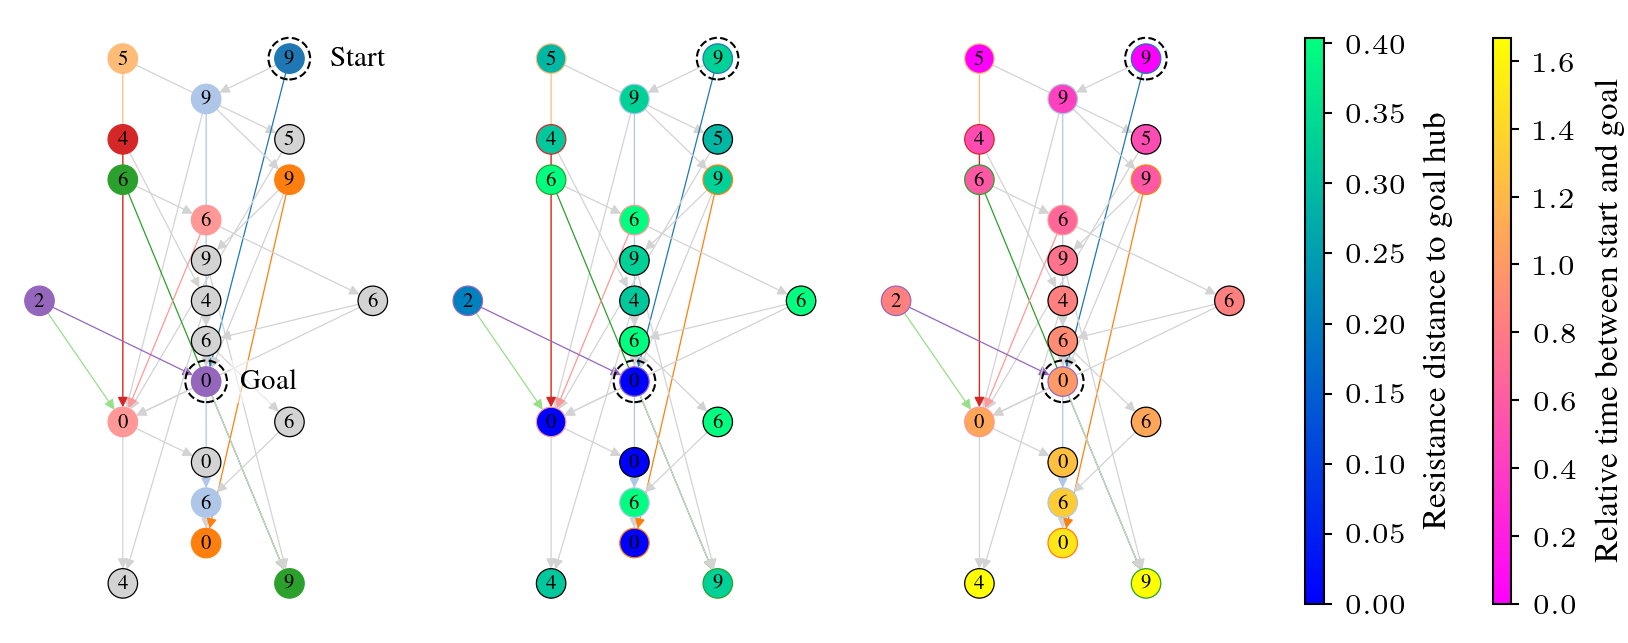

In [276]:
scale_factor = 0.8  # Plotting scale
num_hubs = 20  # Number of depots in the network.
timesteps = 20  # Number of time steps.
num_parcels = 50  # Number of parcels.

# Create middle-mile environment and initialize state.
env = mdp.MiddleMileMDP(
    num_hubs=num_hubs,
    timesteps=timesteps,
    num_trucks_per_step=num_hubs,
    max_truck_duration=timesteps // 2,
    num_parcels=num_parcels,
    mean_route_length=timesteps // 2,
    cut_capacities=1
)
rng = np.random.default_rng(42)
state, _ = env.reset(rng)
state = state4

# Plot state.
# fig, ax = plt.subplots(figsize=(num_hubs * scale_factor, timesteps * scale_factor))
# graph_utils.draw_network(state, ax)

# Show 3-step feature graph for first parcel.
parcel = np.where(state.edges[:, graph_utils.EdgeFeatures.PARCEL_FORWARD] == 1)[0][0]
_, feature_graph, *_ = env.get_feature_graph(2, state, parcel)
fig, ax = plt.subplots(1, 3, figsize=(W, W/2.5))
# plt.rcParams['axes.titlesize'] = 8
# ax[0].set_title("No node features")
# ax[1].set_title("Resistance distance to goal")
# ax[2].set_title("Relative time (start=0, goal=1)")
graph_utils.draw_network(
    feature_graph, ax[0], 
    draw_kwargs={'node_size': 50, 'font_size': 5, 'width': 0.3, 'arrowsize': 5, 'linewidths': 0.3}
)
graph_utils.draw_network(
    feature_graph, ax[1], node_feature=2,
    draw_kwargs={'node_size': 50, 'font_size': 5, 'width': 0.3, 'arrowsize': 5, 'linewidths': 0.3, 'cmap': 'winter'}
)
graph_utils.draw_network(
    feature_graph, ax[2], node_feature=3,
    draw_kwargs={'node_size': 50, 'font_size': 5, 'width': 0.3, 'arrowsize': 5, 'linewidths': 0.3, 'cmap': 'spring'}
)

ax[0].scatter([0.733], [9.09], s=100, ec='k', fc='none', ls='--', zorder=1000)
ax[0].scatter([0], [-2.65], s=100, ec='k', fc='none', ls='--', zorder=1000)
ax[1].scatter([0.733], [9.09], s=100, ec='k', fc='none', ls='--', zorder=1000)
ax[1].scatter([0], [-2.65], s=100, ec='k', fc='none', ls='--', zorder=1000)
ax[2].scatter([0.733], [9.09], s=100, ec='k', fc='none', ls='--', zorder=1000)
ax[2].scatter([0], [-2.65], s=100, ec='k', fc='none', ls='--', zorder=1000)

ax[0].text(1.1, 9.1, 'Start', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, ec='none', boxstyle='square'))
ax[0].text(0.3, -2.65, 'Goal', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, ec='none', boxstyle='square'))

norm = Normalize(feature_graph.nodes[:, 3].min(), feature_graph.nodes[:, 3].max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='spring'), ax=ax[2], pad=0.1, shrink=0.89, aspect=30)
cbar.ax.tick_params(length=2, width=0.5, direction='out')
cbar.set_label(r'Relative time between start and goal', fontsize=8)
norm = Normalize(feature_graph.nodes[:, 2].min(), feature_graph.nodes[:, 2].max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='winter'), ax=ax[2], pad=0.1, shrink=0.89, aspect=30)
cbar.ax.tick_params(length=2, width=0.5, direction='out')
cbar.set_label(r'Resistance distance to goal hub', fontsize=8)

fig.savefig('../out/feature-graphs.pdf')

Deliveries: 6 / 6


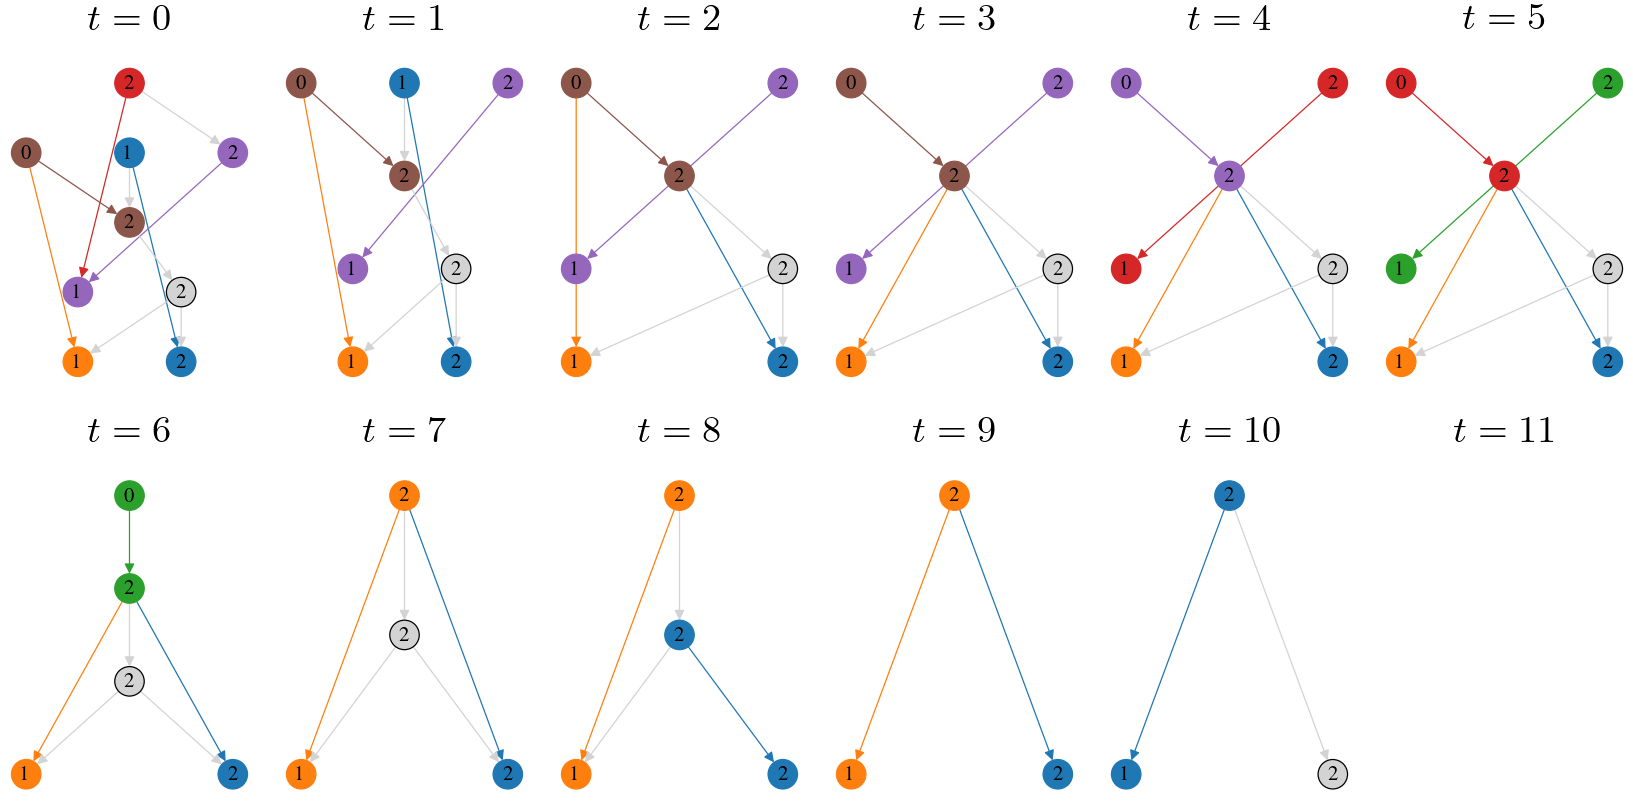

In [7]:
num_hubs = 3  # Number of depots in the network.
timesteps = 5  # Number of time steps.
num_parcels = 6  # Number of parcels in the network.

# Create middle-mile environment and initialize state.
env = mdp.MiddleMileMDP(
    num_hubs=num_hubs,
    timesteps=timesteps,
    num_trucks_per_step=num_hubs,
    max_truck_duration=3,
    num_parcels=num_parcels,
    mean_route_length=3,
    cut_capacities=1
)
rng = np.random.default_rng(42)
state, _ = env.reset(rng)

# Simulate MDP.
states = [state]
deliveries = 0
iterations = 0
while True:
  iterations += 1
  # Get next parcel and available trucks.
  state, parcel, trucks = env.get_actions(state)
  if parcel is None:
    break

  # Put parcel onto random truck, get next state.
  truck = rng.choice(trucks)
  state, delivery, _ = env.step(parcel, truck, state)
  states.append(state)
  deliveries += delivery

print(f"Deliveries: {deliveries} / {num_parcels}")

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.get_cmap('tab10').colors)

# Plot simulation.
cols = 6
rows = int(np.ceil(iterations / cols))
# plt.rcParams['axes.titlesize'] = 24
fig, ax = plt.subplots(
    rows,
    cols,
    figsize=(W, W/2)
)
ax = ax.ravel()
for a in ax:
  a.set_axis_off()
for i, state in enumerate(states):
  ax[i].set_title(f"$t = {i}$")
  graph_utils.draw_network(state, ax[i], draw_kwargs={'node_size': 50, 'font_size': 5, 'width': 0.3, 'arrowsize': 5, 'linewidths': 0.3})

fig.savefig('../out/step-pruning.pdf')

In [8]:
nums_parcels = [10, 20, 50, 100, 200, 500, 1000]
num_trials = 5
no_prune_times = np.zeros((len(nums_parcels), num_trials))
no_prune_iterations = np.zeros((len(nums_parcels), num_trials))
just_pp_times = np.zeros((len(nums_parcels), num_trials))
just_pp_iterations = np.zeros((len(nums_parcels), num_trials))
just_cs_times = np.zeros((len(nums_parcels), num_trials))
just_cs_iterations = np.zeros((len(nums_parcels), num_trials))
prune_times = np.zeros((len(nums_parcels), num_trials))
prune_iterations = np.zeros((len(nums_parcels), num_trials))

rng = np.random.default_rng(42)
for i, num_parcels in enumerate(tqdm(nums_parcels)):
  for j in tqdm(range(num_trials), leave=False):
    num_hubs = 10  # Number of depots in the network.
    timesteps = 50  # Number of time steps.
    num_trucks_per_step = num_hubs

    # Create middle-mile environment and initialize state.
    env = mdp.MiddleMileMDP(
        num_hubs=num_hubs,
        timesteps=timesteps,
        num_trucks_per_step=num_trucks_per_step,
        max_truck_duration=5,
        num_parcels=num_parcels,
        mean_route_length=10,
        unit_weights=True,
        unit_capacities=True,
    )
    init_state, _ = env.reset(rng)

    # With pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state)

    prune_times[i, j] = time.time() - start
    prune_iterations[i, j] = iterations

    # Just parcel pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state, prune=False)

    just_pp_times[i, j] = time.time() - start
    just_pp_iterations[i, j] = iterations

    # Just step pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state, prune_parcel=False)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state)

    just_cs_times[i, j] = time.time() - start
    just_cs_iterations[i, j] = iterations

    # Without pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state, prune_parcel=False)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state, prune=False)

    no_prune_times[i, j] = time.time() - start
    no_prune_iterations[i, j] = iterations

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

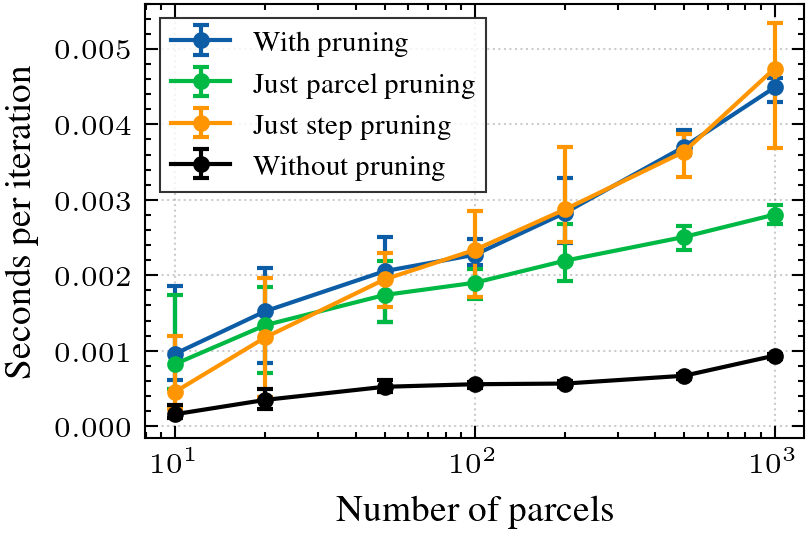

In [298]:
plt.rcParams['axes.prop_cycle'] = cycle

xlim = (7.943282347242816, 1258.9254117941675)

# Plot speeds.
fig, ax = plt.subplots(figsize=(W/2, W/3))
# ax.set_title("Uniform policies on 10-hub/50-timestep network (5 runs min/max/mean)")
ax.set_xlabel("Number of parcels")
ax.set_ylabel(r"Seconds per iteration")
ax.set_xscale('log')
prune_times[prune_times == 0] = np.nan
just_pp_times[just_pp_times == 0] = np.nan
just_cs_times[just_cs_times == 0] = np.nan
no_prune_times[no_prune_times == 0] = np.nan
prune_times_ = prune_times / prune_iterations
just_pp_times_ = just_pp_times / just_pp_iterations
just_cs_times_ = just_cs_times / just_cs_iterations
no_prune_times_ = no_prune_times / no_prune_iterations
ax.errorbar(
    nums_parcels,
    np.nanmean(prune_times_, 1),
    np.stack([
        np.nanmean(prune_times_, 1) - np.nanmin(prune_times_, 1),
        np.nanmax(prune_times_, 1) - np.nanmean(prune_times_, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='With pruning'
)
ax.errorbar(
    nums_parcels,
    np.nanmean(just_pp_times_, 1),
    np.stack([
        np.nanmean(just_pp_times_, 1) - np.nanmin(just_pp_times_, 1), 
        np.nanmax(just_pp_times_, 1) - np.nanmean(just_pp_times_, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='Just parcel pruning'
)
ax.errorbar(
    nums_parcels,
    np.nanmean(just_cs_times_, 1),
    np.stack([
        np.nanmean(just_cs_times_, 1) - np.nanmin(just_cs_times_, 1), 
        np.nanmax(just_cs_times_, 1) - np.nanmean(just_cs_times_, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='Just step pruning'
)
ax.errorbar(
    nums_parcels,
    np.nanmean(no_prune_times_, 1),
    np.stack([
        np.nanmean(no_prune_times_, 1) - np.nanmin(no_prune_times_, 1), 
        np.nanmax(no_prune_times_, 1) - np.nanmean(no_prune_times_, 1)
    ]),
    fmt='k.-',
    capsize=2,
    label='Without pruning'
)
ax.set_xlim(*xlim)
ax.legend()
fig.savefig('../out/pruning-times.pdf')

In [39]:
# One-step vs. all-step vs. last-parcel routing (no pruning).
nums_parcels = [10, 20, 50, 100, 200, 500, 1000]
num_trials = 5
one_perf_no = np.zeros((len(nums_parcels), num_trials))
all_perf_no = np.zeros((len(nums_parcels), num_trials))
last_perf_no = np.zeros((len(nums_parcels), num_trials))

rng = np.random.default_rng(42)
for i, num_parcels in enumerate(tqdm(nums_parcels)):
  for j in tqdm(range(num_trials), leave=False):
    num_hubs = 10  # Number of depots in the network.
    timesteps = 50  # Number of time steps.
    num_trucks_per_step = num_hubs

    # Create middle-mile environment and initialize state.
    env = mdp.MiddleMileMDP(
        num_hubs=num_hubs,
        timesteps=timesteps,
        num_trucks_per_step=num_trucks_per_step,
        max_truck_duration=5,
        num_parcels=num_parcels,
        mean_route_length=10,
        unit_weights=True,
        unit_capacities=True,
    )
    initial_state, _ = env.reset(rng)

    # One-step rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state, prune_parcel=False)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, parcel = env.step(parcel, truck, state, prune=False)
      deliveries += delivery

    # Record performance.
    one_perf_no[i, j] = deliveries / num_parcels

    # All-step rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel.
      state, parcel, _ = env.get_next_parcel(state, prune_parcel=False)
      if parcel is None:
        break

      # Route parcel.
      while parcel is not None:
        state, parcel, trucks = env.get_actions(
          state, parcel, prune_parcel=False
        )
        if parcel is None:
          break

        # Put parcel onto random truck, get next state.
        truck = rng.choice(trucks)
        state, delivery, parcel = env.step(parcel, truck, state, prune=False)
        deliveries += delivery

    # Record performance.
    all_perf_no[i, j] = deliveries / num_parcels

    # Last-parcel rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(
        state, prune_parcel=False, last_parcel=True
      )
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, parcel = env.step(parcel, truck, state, prune=False)
      deliveries += delivery

    # Record performance.
    last_perf_no[i, j] = deliveries / num_parcels

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [42]:
# One-step vs. all-step vs. last-parcel routing (all with pruning).
nums_parcels = [10, 20, 50, 100, 200, 500, 1000]
num_trials = 5
one_perf = np.zeros((len(nums_parcels), num_trials))
all_perf = np.zeros((len(nums_parcels), num_trials))
last_perf = np.zeros((len(nums_parcels), num_trials))

rng = np.random.default_rng(42)
for i, num_parcels in enumerate(tqdm(nums_parcels)):
  for j in tqdm(range(num_trials), leave=False):
    num_hubs = 10  # Number of depots in the network.
    timesteps = 50  # Number of time steps.
    num_trucks_per_step = num_hubs

    # Create middle-mile environment and initialize state.
    env = mdp.MiddleMileMDP(
        num_hubs=num_hubs,
        timesteps=timesteps,
        num_trucks_per_step=num_trucks_per_step,
        max_truck_duration=5,
        num_parcels=num_parcels,
        mean_route_length=10,
        unit_weights=True,
        unit_capacities=True,
    )
    initial_state, _ = env.reset(rng)

    # One-step rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, parcel = env.step(parcel, truck, state)
      deliveries += delivery

    # Record performance.
    one_perf[i, j] = deliveries / num_parcels

    # All-step rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel.
      state, parcel, _ = env.get_next_parcel(state)
      if parcel is None:
        break

      # Route parcel.
      while parcel is not None:
        state, parcel, trucks = env.get_actions(
          state, parcel
        )
        if parcel is None:
          break

        # Put parcel onto random truck, get next state.
        truck = rng.choice(trucks)
        state, delivery, parcel = env.step(parcel, truck, state)
        deliveries += delivery

    # Record performance.
    all_perf[i, j] = deliveries / num_parcels

    # Last-parcel rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(
        state, last_parcel=True
      )
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, parcel = env.step(parcel, truck, state)
      deliveries += delivery

    # Record performance.
    last_perf[i, j] = deliveries / num_parcels

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

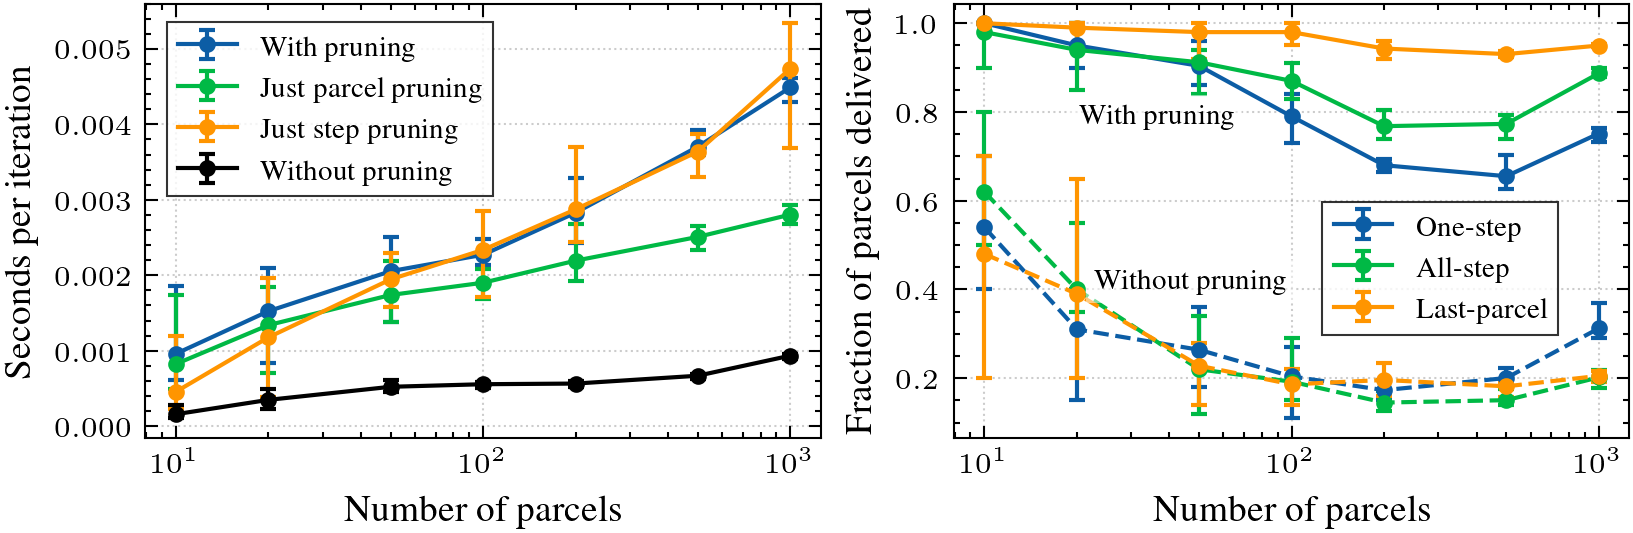

In [299]:
xlim = (7.943282347242816, 1258.9254117941675)
plt.rcParams['axes.prop_cycle'] = cycle

fig, ax = plt.subplots(1, 2, figsize=(W, W/3), sharex=True)
ax[0].set_xlabel("Number of parcels")
ax[0].set_ylabel(r"Seconds per iteration")
ax[0].set_xscale('log')
ax[1].set_xlabel("Number of parcels")
ax[1].set_ylabel(r"Fraction of parcels delivered")
# ax[1].set_xscale('log')

prune_times[prune_times == 0] = np.nan
just_pp_times[just_pp_times == 0] = np.nan
just_cs_times[just_cs_times == 0] = np.nan
no_prune_times[no_prune_times == 0] = np.nan
prune_times_ = prune_times / prune_iterations
just_pp_times_ = just_pp_times / just_pp_iterations
just_cs_times_ = just_cs_times / just_cs_iterations
no_prune_times_ = no_prune_times / no_prune_iterations
ax[0].errorbar(
    nums_parcels,
    np.nanmean(prune_times_, 1),
    np.stack([
        np.nanmean(prune_times_, 1) - np.nanmin(prune_times_, 1),
        np.nanmax(prune_times_, 1) - np.nanmean(prune_times_, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='With pruning'
)
ax[0].errorbar(
    nums_parcels,
    np.nanmean(just_pp_times_, 1),
    np.stack([
        np.nanmean(just_pp_times_, 1) - np.nanmin(just_pp_times_, 1), 
        np.nanmax(just_pp_times_, 1) - np.nanmean(just_pp_times_, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='Just parcel pruning'
)
ax[0].errorbar(
    nums_parcels,
    np.nanmean(just_cs_times_, 1),
    np.stack([
        np.nanmean(just_cs_times_, 1) - np.nanmin(just_cs_times_, 1), 
        np.nanmax(just_cs_times_, 1) - np.nanmean(just_cs_times_, 1)
    ]),
    fmt='.-',
    capsize=2,
    label='Just step pruning'
)
ax[0].errorbar(
    nums_parcels,
    np.nanmean(no_prune_times_, 1),
    np.stack([
        np.nanmean(no_prune_times_, 1) - np.nanmin(no_prune_times_, 1), 
        np.nanmax(no_prune_times_, 1) - np.nanmean(no_prune_times_, 1)
    ]),
    fmt='k.-',
    capsize=2,
    label='Without pruning'
)
ax[0].set_xlim(*xlim)
ax[0].legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
# fig.savefig('../out/pruning-times.pdf')

one_perf[one_perf == 0] = np.nan
all_perf[all_perf == 0] = np.nan
last_perf[last_perf == 0] = np.nan
one_perf_no[one_perf_no == 0] = np.nan
all_perf_no[all_perf_no == 0] = np.nan
last_perf_no[last_perf_no == 0] = np.nan
ax[1].errorbar(
    nums_parcels,
    np.nanmean(one_perf, 1),
    np.stack([
        np.nanmean(one_perf, 1) - np.nanmin(one_perf, 1),
        np.nanmax(one_perf, 1) - np.nanmean(one_perf, 1)
    ]),
    fmt='C0.-',
    capsize=2,
    label='One-step'
)
ax[1].errorbar(
    nums_parcels,
    np.nanmean(all_perf, 1),
    np.stack([
        np.nanmean(all_perf, 1) - np.nanmin(all_perf, 1),
        np.nanmax(all_perf, 1) - np.nanmean(all_perf, 1)
    ]),
    fmt='C1.-',
    capsize=2,
    label='All-step'
)
ax[1].errorbar(
    nums_parcels,
    np.nanmean(last_perf, 1),
    np.stack([
        np.nanmean(last_perf, 1) - np.nanmin(last_perf, 1),
        np.nanmax(last_perf, 1) - np.nanmean(last_perf, 1)
    ]),
    fmt='C2.-',
    capsize=2,
    label='Last-parcel'
)
ax[1].errorbar(
    nums_parcels,
    np.nanmean(one_perf_no, 1),
    np.stack([
        np.nanmean(one_perf_no, 1) - np.nanmin(one_perf_no, 1),
        np.nanmax(one_perf_no, 1) - np.nanmean(one_perf_no, 1)
    ]),
    fmt='.--',
    capsize=2,
)
ax[1].errorbar(
    nums_parcels,
    np.nanmean(all_perf_no, 1),
    np.stack([
        np.nanmean(all_perf_no, 1) - np.nanmin(all_perf_no, 1),
        np.nanmax(all_perf_no, 1) - np.nanmean(all_perf_no, 1)
    ]),
    fmt='.--',
    capsize=2,
)
ax[1].errorbar(
    nums_parcels,
    np.nanmean(last_perf_no, 1),
    np.stack([
        np.nanmean(last_perf_no, 1) - np.nanmin(last_perf_no, 1),
        np.nanmax(last_perf_no, 1) - np.nanmean(last_perf_no, 1)
    ]),
    fmt='.--',
    capsize=2,
)
ax[1].legend(loc='center', bbox_to_anchor=(0.72, 0.39))
ax[1].text(0.3, 0.74, 'With pruning', transform=ax[1].transAxes, ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, ec='none', boxstyle='square'))
ax[1].text(0.35, 0.36, 'Without pruning', transform=ax[1].transAxes, ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, ec='none', boxstyle='square'))
ax[0].set_xlim(*xlim)
# ax.set_xlim(*xlim)
fig.savefig('../out/random-pruning.pdf')